In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd

plt.style.use("ggplot")

# Estimating fluxes using NivaPy

Nivapy includes some simple functions for estimating riverine fluxes (also know as "loads"). This notebook creates a synthetic dataset based on discharge data from Langtjern and compares the various methods.

## 1. Read Langtjern discharge data

In [2]:
# Read CSV data
csv_path = r"/home/jovyan/dstoolkit_examples/data/csv/langtjern_daily_flows.csv"
df = pd.read_csv(csv_path, parse_dates=True, index_col=0)

# Linear interp. of missing data
df.interpolate(method="linear", inplace=True)

# Flux functions require column named 'flow_m3/s'
df.rename({"flow_m3ps": "flow_m3/s"}, inplace=True, axis="columns")

df.head()

,flow_m3/s
date,
1990-01-01,0.00655
1990-01-02,0.00655
1990-01-03,0.00472
1990-01-04,0.00472
1990-01-05,0.00472


## 2. Create "fake" concentration data

We assume a log-log relationship between discharge and concentration (which is often theorised and *sometimes* observed in reality). The aim is just to generate a vaguely plausible timeseries of daily concentrations that can be used as a reference.

$$log(C) = m * log(Q) + log(\alpha) + \epsilon$$

where $\epsilon \sim \mathcal{N}(0,\,\sigma^{2})$

/opt/conda/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

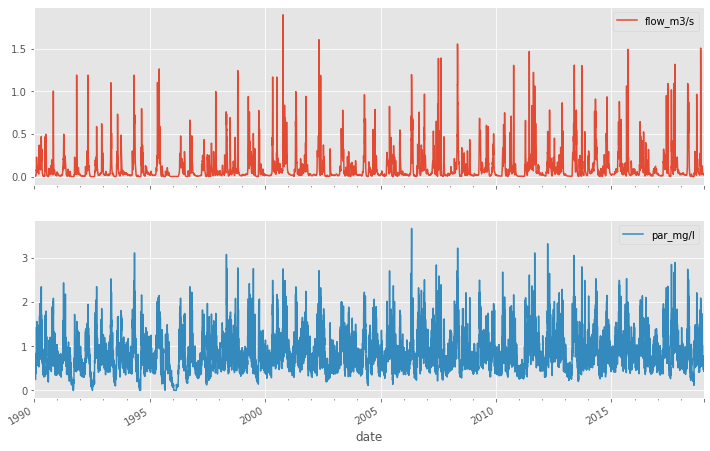

In [3]:
# Create fake data
m = 0.3
alpha = 2
sigma = 0.1

# Calculate concentrations
np.random.seed(0)
df["par_mg/l"] = 10 ** (
    m * np.log10(df["flow_m3/s"])
    + np.log10(alpha)
    + np.random.normal(loc=0, scale=sigma, size=len(df["flow_m3/s"]))
)

df.plot(subplots=True, figsize=(12, 8))

## 3. Estimate "true" fluxes

In [4]:
# "True" flux
df["true_flux_kg"] = 1000 * 24 * 60 * 60 * df["flow_m3/s"] * df["par_mg/l"] / 1e6
ann_true_df = df.resample("A").sum()[["true_flux_kg"]]
ann_true_df.index = ann_true_df.index.year
ann_true_df.head()

,true_flux_kg
date,
1990,3359.202682
1991,2169.539785
1992,2546.644534
1993,3430.799067
1994,4442.557537


## 4. Estimate fluxes with NivaPy

### 4.1. Using all data

Using the "full" series should give similar results to the "true" series (except when `method='simple_means'`, which is very biased). This isn't very useful, but should test for implementation errors in the code

In [5]:
# Get help for nivapy flux estimation methods
nivapy.stats.estimate_fluxes?

Signature:
nivapy.stats.estimate_fluxes(
    q_df,
    chem_df,
    base_freq='D',
    agg_freq='A',
    method='linear_interpolation',
    st_date=None,
    end_date=None,
    plot_fold=None,
)
Docstring:
Takes dataframes of discharge (in m3/s) and water chemistry (in units of mg/l, ug/l and/or ng/l) and estimates
river fluxes (also known as loads). The API is rather limited at present, and should be improved. Currently
implements the following methods of flux estimation:

    - linear_interpolation. chem_df is resampled to the same base frequency as q_df and any data gaps are patched
      by linear interpolation. Fluxes are then calculated for each time step at the base frequency and summed to
      the desired aggregation frequency. Simple, but biased unless you have fairly high-frequency,
      regular sampling of water chemistry

    - simple_means. chem_df and q_df are resampled to the specified aggregation frequency by taking means.
      Fluxes for each aggregated timestep are

In [6]:
# Extract datasets
q_df = df[["flow_m3/s"]].copy()
conc_df = df[["par_mg/l"]].copy()

# Container for results
df_list = []

# Loop over methods
for method in [
    "linear_interpolation",
    "simple_means",
    "log_log_linear_regression",
    "ospar_annual",
]:
    print(f"Processing: {method}")
    # Estimate fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        q_df, conc_df, base_freq="D", agg_freq="A", method=method
    )

    # Delete flow vol, as interested in TOC
    if method != "ospar_annual":
        del flux_df["flow_m3"]

        # Convert date-times to integer years
        flux_df.index = flux_df.index.year

    # Rename col with method name for later
    flux_df.columns = [method]

    # Add to results
    df_list.append(flux_df)

# Merge results
flux_df = pd.concat(df_list, axis="columns")

flux_df.head()

Processing: linear_interpolation
Processing: simple_means
Processing: log_log_linear_regression
Regression results:
      param     slope  intercept  r_squared
0  par_mg/l  0.299223   0.298263   0.805472
Processing: ospar_annual


,linear_interpolation,simple_means,log_log_linear_regression,ospar_annual
1990,3359.202682,2306.439441,3359.202682,3358.427588
1991,2169.539785,1387.039075,2169.543190,2169.735099
1992,2546.644534,1480.798668,2546.646577,2546.280538
1993,3430.799067,2006.376432,3430.799067,3431.153884
1994,4442.557537,2305.166972,4442.661639,4442.458050


These results compare well to the true/reference fluxes above, which suggests the code is working as expected.

### 4.2. Consider only monthly sampling

What if we include only every 30th observation from the concentration data (i.e. approximately monthly sampling)? This is a more realistic test of the statistical properties of each algorithm.

In [7]:
# Extract datasets
q_df = df[["flow_m3/s"]].copy()
conc_df = df[["par_mg/l"]].copy()

# Use every 30th conc measurement
conc_df = pd.concat([q_df, conc_df[::30]], axis="columns")[["par_mg/l"]]

# Container for results
df_list = []

# Loop over methods
for method in [
    "linear_interpolation",
    "simple_means",
    "log_log_linear_regression",
    "ospar_annual",
]:
    print(f"Processing: {method}")
    # Estimate fluxes
    flux_df = nivapy.stats.estimate_fluxes(
        q_df, conc_df, base_freq="D", agg_freq="A", method=method
    )

    # Delete flow vol, as interested in TOC
    if method != "ospar_annual":
        del flux_df["flow_m3"]

        # Convert date-times to integer years
        flux_df.index = flux_df.index.year

    # Rename col with method name for later
    flux_df.columns = [method]

    # Add to results
    df_list.append(flux_df)

# Merge results
flux_df = pd.concat(df_list, axis="columns")

flux_df.head()

Processing: linear_interpolation
Processing: simple_means
Processing: log_log_linear_regression
Regression results:
      param     slope  intercept  r_squared
0  par_mg/l  0.302443   0.303984   0.798549
Processing: ospar_annual


,linear_interpolation,simple_means,log_log_linear_regression,ospar_annual
1990,2554.921023,2220.750296,3405.312862,3174.463296
1991,1684.550803,1388.028900,2374.503342,1785.854129
1992,2161.712869,1586.358264,2681.469089,2386.744863
1993,2687.291696,2009.799696,3501.961582,3709.003461
1994,3210.878338,2129.456830,4326.962928,3651.978098


Note that `method='log_log_linear_regression'` does a good job of estimating the correct regression coefficients here: $m = 0.3$ and $\alpha = 2 = 10^{0.3}$.

## 5. Compare estimates to true values

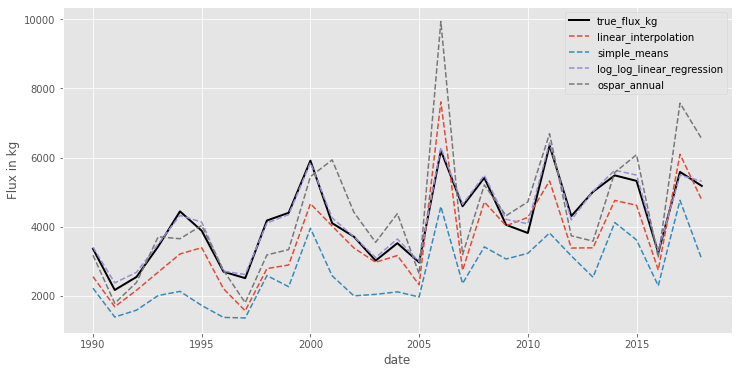

In [8]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ann_true_df.plot(ax=ax, lw=2, c="k")
flux_df.plot(ax=ax, style="--")
_ = ax.set_ylabel("Flux in kg")

Unsurprisingly, the log-log regression method works very well here, because the "fake" data were generated by assuming a (noisy) log-log relationship, so the $R^2$ value is very high in this example compared to what is usually observed in reality. The OSPAR approach is also reasonable (although it overestimates in 2006 for some reason), while the other two methods tend to underestimate fluxes. This is largely as expected from statistical theory.

A more detailed understanding of the performance of each algorithm could be obtained by **bootstrap resampling** the synthetic concentration dataset, but this is not covered here.